### 0. Import Dependencies

In [2]:
import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

### 1.a. Data processing (FER 2013 Dataset)

Firstly, we create a function that will return the images and the labels, given a dataset:

In [5]:
from custom_dataset import CustomDataset

The dataset was taken from this source: https://www.kaggle.com/code/ayushsaini04/face-expression-recognition-with-deep-learning

All images have a resolution 48x48. The images appearing in the plot are random images of the train dataset.

In [4]:
# input path for the images FER 2013
base_path = "data/fer2013/images/"

Let's count the number of images for each facial expression in the FER 2013 dataset:

In [5]:
import os
print("No. of images in the training split: (FER dataset) ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: (FER dataset)")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: (FER dataset) 
3205 surprise images
436 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: (FER dataset)
797 surprise images
111 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


The "disgust" images appear to be much lesser than the other categories. This significant imbalance could potentially cause problems to the model.

A good solution to this issue is to augment the images of the "disgust" dataset, so that we create more samples of this class and thus improve the model's accuracy.

Original: 


/tmp/ipykernel_202588/2176752717.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))


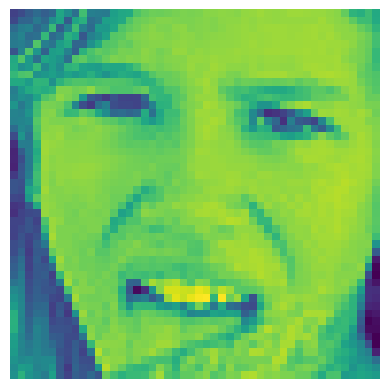

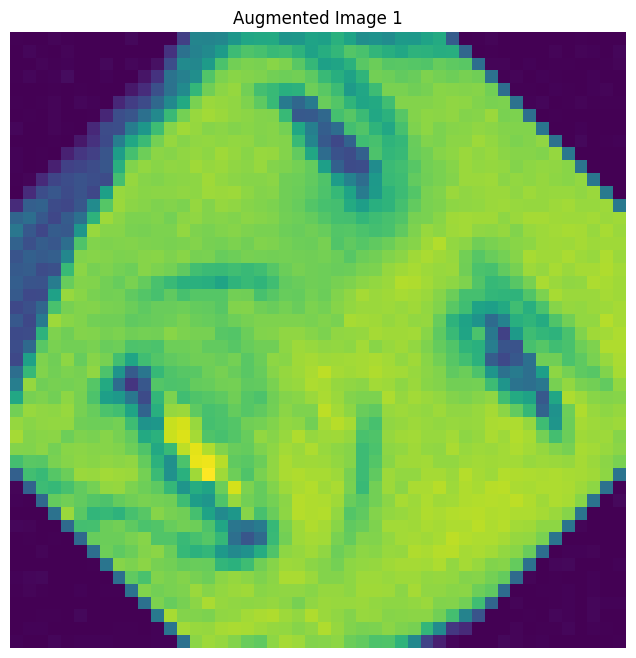

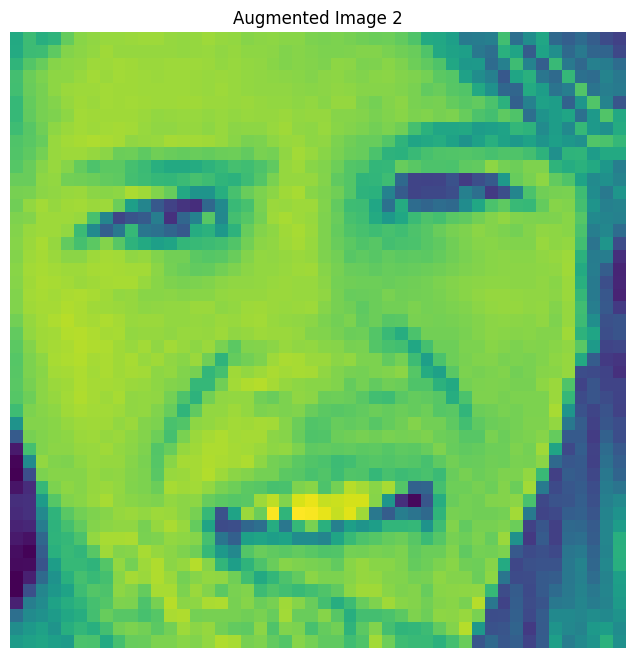

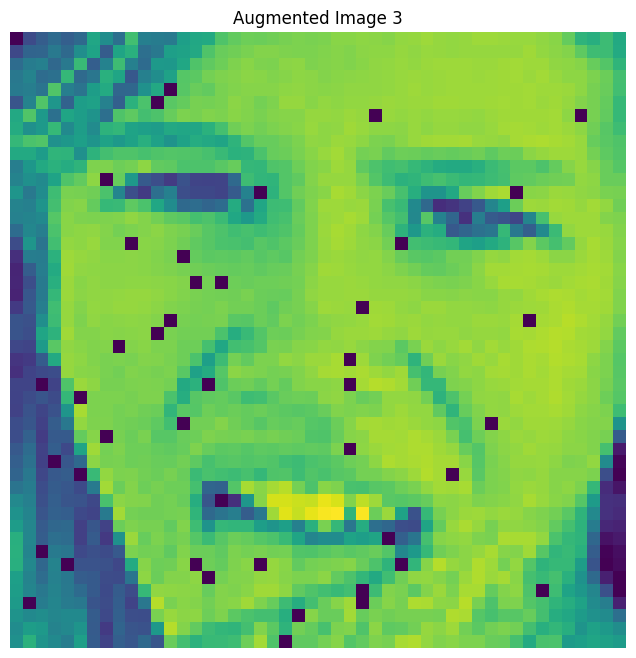

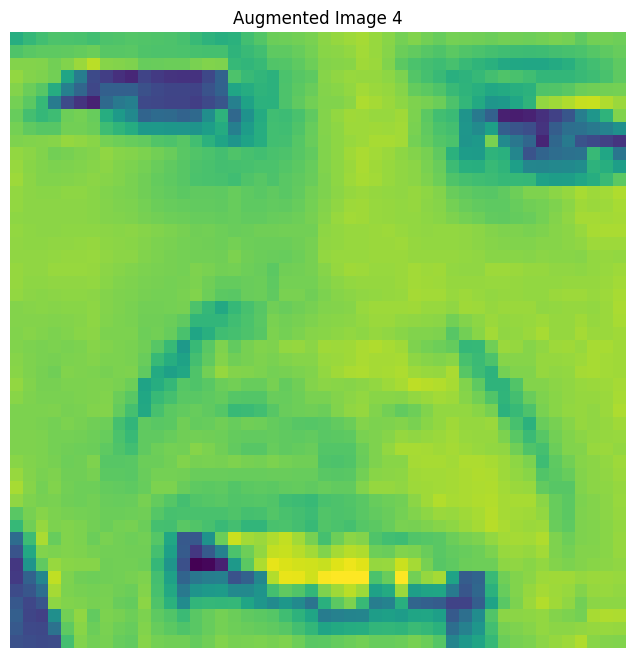

In [6]:
# Load a random image and display it

import imageio
import imgaug as ia
import matplotlib.pyplot as plt
import random

%matplotlib inline

disgust_path = base_path + "/train/disgust/"
disgust_path_val = base_path + "/validation/disgust/"
image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))

print("Original: ")
plt.imshow(image)
plt.axis('off')
plt.show()

# Augment the Image

from imgaug import augmenters as iaa
ia.seed(4)

# Define different sequential augmenters
seq1 = iaa.Sequential([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.01*255)
])

seq2 = iaa.Sequential([
    iaa.Fliplr(1)  # Horizontal flip
])

seq3 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.01, 0.05)),
    iaa.Dropout(p=(0.01, 0.05)),
])

seq4 = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)),  # random crops
    iaa.Sharpen(alpha=(0.01, 0.05))  # sharpen the image
])

# List of all sequentials
sequentials = [seq1, seq2, seq3, seq4]


for i, seq in enumerate(sequentials, start=1):
    # Apply augmentation
    image_aug = seq(image=image)
    
    # Display the augmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_aug)
    plt.axis('off')
    plt.title(f'Augmented Image {i}')
    plt.show()

We are going to do the same thing as in the above cell but for all the images in the "disgust" folder, in order to increase the number of samples we are going to use for our training.

(In case we want to delete some of the images we just created, we can run this script) :

In [6]:
import os

disgust_path = "data/fer2013/images/train/disgust/" # add the path here
disgust_path_val = "data/fer2013/images/validation/disgust/"
# List all files in the directory
files_in_directory = os.listdir(disgust_path) 
files_in_directory_val = os.listdir(disgust_path_val)
files_to_delete = []

# Filter for files that end with '_aug.jpg'
for file in files_in_directory:    
    for i in range(0, 5):
        if file.endswith(f'_aug{i}.jpg'):
            files_to_delete.append(file)

# Delete the files
for file in files_to_delete:
    os.remove(os.path.join(disgust_path, file))
    print(f"Deleted {file}")

files_to_delete = []

for file in files_in_directory_val:
    for i in range(0, 5):
        if file.endswith(f'_aug{i}.jpg'):
            files_to_delete.append(file)

for file in files_to_delete:
    os.remove(os.path.join(disgust_path_val, file))
    print(f"Deleted {file}")


In [7]:
run_once=False

Now we create the new augmented pictures:

In [8]:
if run_once == False:
    for pic in os.listdir(disgust_path):
        image = imageio.imread(disgust_path + pic)
        for i, seq in enumerate(sequentials, start=1):
            image_aug = seq(image=image)
            imageio.imwrite(os.path.join(disgust_path, pic[:-4] + f"_aug{i}.jpg"), image_aug)
    
if run_once == True:
    print("Augmentation already done")
run_once = True

/tmp/ipykernel_202588/2480205506.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + pic)


In [9]:
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
2180 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
111 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


Now we see that our dataset is more balanced.

### 1.b. Data processing (Affectnet)

Data Augmentation for Affectnet Dataset:

(Deletion cell like FER2013):

In [74]:
import os
from pathlib import Path

path = Path.cwd().parent / "data/affectnet/images/" # add the path here
# List all files in the directory
folders_in_directory = os.listdir(path)

for folder_path in base_path.iterdir():
    if folder_path.is_dir():  
        print(f"Processing {folder_path.name}")

        # Filter for files that start with 'aug'
        files_to_delete = [file for file in folder_path.glob('aug*')]  

        # Delete the files
        for file_path in files_to_delete:
            file_path.unlink()  # Using unlink method from pathlib to remove the file
            print(f"Deleted {file_path.name}")

Processing surprise
Deleted aug_image0028789.jpg
Deleted aug_image0017057.jpg
Deleted aug_image0012128.jpg
Deleted aug_image0016632.jpg
Deleted aug_image0023369.jpg
Deleted aug_image0032568.jpg
Deleted aug_image0031205.jpg
Deleted aug_image0008953.jpg
Deleted aug_image0026730.jpg
Deleted aug_image0021315.jpg
Deleted aug_ffhq_438.png
Deleted aug_image0023848.jpg
Deleted aug_image0019426.jpg
Deleted aug_image0032669.jpg
Deleted aug_image0014678.jpg
Deleted aug_image0017976.jpg
Deleted aug_image0021187.jpg
Deleted aug_image0018550.jpg
Deleted aug_image0031036.jpg
Deleted aug_ffhq_537.png
Deleted aug_image0034610.jpg
Deleted aug_image0033790.jpg
Deleted aug_image0020479.jpg
Deleted aug_image0028783.jpg
Deleted aug_image0028444.jpg
Deleted aug_image0019734.jpg
Deleted aug_image0019981.jpg
Deleted aug_ffhq_448.png
Deleted aug_image0033053.jpg
Deleted aug_ffhq_145.png
Deleted aug_ffhq_295.png
Deleted aug_image0018938.jpg
Deleted aug_image0002039.jpg
Deleted aug_image0032844.jpg
Deleted aug_im

In [75]:

import imageio
import imgaug as ia
import matplotlib.pyplot as plt
import random
from imgaug import augmenters as iaa
from pathlib import Path


%matplotlib inline

base_path = Path.cwd().parent / "data/affectnet/images/"

def sometimes(aug): return iaa.Sometimes(0.3, aug)

augmentations = iaa.Sequential([
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # 80-120% of their size
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # Translate by -20 to +20 percent (per axis)
        rotate=(-15, 15), # Rotate by -15 to +15 degrees
        shear=(-8, 8) # Shear by -8 to +8 degrees
    )),
    sometimes(iaa.AdditiveGaussianNoise(scale=0.001*255)), # Add Gaussian Noise
    sometimes(iaa.ContrastNormalization((0.75, 1.5))), # Adjust contrast
    sometimes(iaa.Multiply((0.8, 1.2))), # Change brightness (80-120% of original value)
    sometimes(iaa.GaussianBlur(sigma=(0.01, 0.05))), # Apply Gaussian Blur with a sigma of 0.01 to 0.05
    sometimes(iaa.Dropout((0.01, 0.1), per_channel=0.5)), # Apply dropout to random pixels
    sometimes(iaa.CoarseDropout(
        (0.03, 0.15), size_percent=(0.02, 0.05),
        per_channel=0.2
    )), # Apply dropout to larger regions
    sometimes(iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.01)) # Apply elastic transformations
], random_order=True) # Apply augmentations in random order

allowed_folders = ["angry", "disgust", "fear", "sad"]

for emotion_dir in os.listdir(base_path):
    if emotion_dir in allowed_folders:
        if not os.path.isdir(base_path / emotion_dir):
            continue

        for image_name in os.listdir(base_path / emotion_dir):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            image_path = base_path / emotion_dir / image_name
            image = imageio.imread(image_path)

            image_aug = augmentations(image=image)

            aug_image_name = f"aug_{image_name}"
            aug_image_path = base_path / emotion_dir / aug_image_name
            imageio.imwrite(aug_image_path, image_aug)

/tmp/ipykernel_467183/3756525757.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [8]:
print("Printing number of samples in AffectNet dataset")
from pathlib import Path
base_path = Path.cwd().parent / "data/affectnet/images/"
for expression in os.listdir(base_path):
    print(str(len(os.listdir(base_path / expression))) + " " + expression + " images")

Printing number of samples in AffectNet dataset
4039 surprise images
4954 disgust images
5044 happy images
6182 sad images
6352 fear images
5126 neutral images
6436 angry images


Split into train and validation set for AffectNet:

In [77]:
import shutil
from sklearn.model_selection import train_test_split

affectnet_path = Path.cwd().parent / "data/affectnet"

train_path = affectnet_path / "train/"
val_path = affectnet_path / "validation/"

val_ratio = 0.2

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

for emotion in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion)
    images = [os.path.join(emotion_path, img) for img in os.listdir(emotion_path)]
    train_images, val_images = train_test_split(images, test_size=val_ratio, random_state=42)

    # Copy training images
    train_emotion_path = os.path.join(train_path, emotion)
    os.makedirs(train_emotion_path, exist_ok=True)
    for img in train_images:
        shutil.copy(img, train_emotion_path)

    # Copy validation images
    val_emotion_path = os.path.join(val_path, emotion)
    os.makedirs(val_emotion_path, exist_ok=True)
    for img in val_images:
        shutil.copy(img, val_emotion_path)

# Checking if the process was executed correctly

for emotion in os.listdir(train_path):
    print(str(len(os.listdir(os.path.join(train_path, emotion)))) + " " + emotion + " images")


3231 surprise images
3963 disgust images
4035 happy images
4945 sad images
5081 fear images
4100 neutral images
5148 angry images


### From this point on, the training and testing are implemented in seperate python files.